In [30]:
# # 1. 가상환경 생성 및 활성화
# python -m venv LangGraph_Test
# # Windows
# LangGraph_Test\Scripts\activate

# # 2. 필요한 패키지 설치
# pip install jupyter notebook
# pip install ipykernel

# # 3. 가상환경을 Jupyter kernel로 등록
# python -m ipykernel install --user --name=LangGraph_Test --display-name="LangGraph_Test"

In [31]:
import requests
import json
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from typing import Literal, TypedDict

In [32]:
# api key
from dotenv import load_dotenv

load_dotenv()

True

In [33]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LANGGRAPH")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LANGGRAPH


In [34]:
from typing import Annotated, TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]
    fng: Optional[dict] = None

In [35]:
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [36]:
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    answer = llm.invoke(state["messages"])
    return {"messages": [answer]} # 자동으로 add_messages 적용

In [37]:
# 공포 탐욕 지수 함수 정의
url = "https://api.alternative.me/fng/?date_format=kr&limit="

def get_fng():
    # 30일로 설정
    _url = url + "30"
    res = requests.request("GET", _url)

    parsed = json.loads(res.text)
    data = parsed["data"]

    # 데이터의 value 값만 리스트로 추출
    values = [int(item['value']) for item in data]

    return values

fng_template = """당신은 투자 분석 전문가 입니다. 
    현재 공포 탐욕 지수의 최근 30일 지수의 정보는 다음과 같습니다: {values}

    분석 결과를 다음 JSON 형식으로 제공해주세요:
    {{
        "decision": "BUY 또는 SELL 또는 HOLD 중 하나로만 작성"
        "summary": "시장 분석 및 예측 내용을 상세히 서술. 투자 결정을 제안하고 해당 이유를 서술",
    }}

    주의사항:
    - decision은 반드시 BUY 또는 SELL 또는 HOLD 중 하나여야 합니다
    - summary는 현재 시장 상황과 향후 전망을 포함해야 합니다. 투자 결정을 제안하고 해당 이유를 서술해야 합니다
    """

fng_prompt_template = PromptTemplate.from_template(fng_template)

class FngAnalysis(TypedDict):
    summary: str
    decision: Literal["BUY", "SELL", "HOLD"]

json_output_parser = JsonOutputParser(pydantic_object=FngAnalysis)

chain = fng_prompt_template | llm | json_output_parser

def fng_agent(state: State) -> State:
    fng_info = get_fng()
    result = chain.invoke({"values": fng_info})

    return {**state, "fng": {"decision": result["decision"], "summary": result["summary"]}}

In [38]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("fng_agent", fng_agent)

In [39]:
# 그래프에 엣지 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "fng_agent")
graph_builder.add_edge("fng_agent", END)

In [40]:
# 그래프 컴파일
graph = graph_builder.compile()

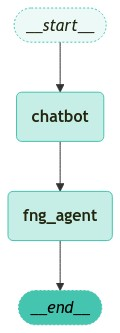

In [41]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [42]:
question = "면접을 잘봤는지 면접관의 반응을 통해 알 수 있을까?"

# State 제공
graph.invoke({"messages": [("user", question)]})

{'messages': [HumanMessage(content='면접을 잘봤는지 면접관의 반응을 통해 알 수 있을까?', additional_kwargs={}, response_metadata={}, id='0003460f-d866-44c7-97fe-ea932d63cd41'),
  AIMessage(content='면접관의 반응은 면접 결과를 예측하는 데 도움이 될 수 있지만, 확실한 지표는 아닙니다. 면접관의 반응을 통해 알 수 있는 몇 가지 요소는 다음과 같습니다:\n\n1. **질문과 대화의 흐름**: 면접관이 질문을 많이 하고, 대화가 자연스럽게 이어진다면 긍정적인 신호일 수 있습니다. 반면, 질문이 적거나 대화가 어색하게 진행된다면 부정적인 신호일 수 있습니다.\n\n2. **비언어적 신호**: 면접관의 표정, 눈 맞춤, 몸짓 등 비언어적 신호도 중요합니다. 긍정적인 표정이나 고개 끄덕임은 좋은 반응으로 해석될 수 있습니다.\n\n3. **피드백**: 면접관이 당신의 답변에 대해 긍정적인 피드백을 주거나, 추가 질문을 통해 더 깊이 있는 대화를 나누고자 한다면 좋은 신호일 수 있습니다.\n\n4. **면접 종료 시의 말**: 면접이 끝날 때 면접관이 "좋은 하루 되세요"와 같은 긍정적인 인사를 하거나, 다음 단계에 대한 언급을 한다면 긍정적인 신호일 수 있습니다.\n\n하지만 이러한 반응이 항상 결과와 일치하는 것은 아니므로, 최종 결과는 기다려봐야 합니다. 면접 후에는 자신이 잘한 점과 개선할 점을 돌아보는 것이 중요합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 330, 'prompt_tokens': 27, 'total_tokens': 357, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details'